Based on: https://www.youtube.com/watch?v=jztwpsIzEGc

## Building Data Pipeline

#### Install Dependencies

In [1]:
#GPU compatibility only for tensorflow versions lower than 2.11
!pip install tensorflow==2.10 opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

In [3]:
#Set GPU Memory Consumption Growth (Limits tensorflow from using all the vRAM on GPU)
#By default, uses all potential vRAM, helps prevent OutOfMemory error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#### Image Data

In [4]:
import cv2 #Computer vision module
import imghdr #Checks image file extensions
from matplotlib import pyplot as plt

In [5]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
os.listdir(data_dir)

['crab', 'fish', 'squid']

Note for Additional cleanup: Manually delete any image files in data folders that are <10kb (too small for good data) or svg files

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            image = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))
#             os.remove(image_path)

#### Load Data

In [8]:
#Tensorflow dataset API: Allows to build a data pipeline instead of loading data to memory
#tf.data.Dataset

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
#Keras: API that provides a python interface for neural networks
#Data pipeline helper function via keras
#Does preprocessing as well, can be altered
data = tf.keras.utils.image_dataset_from_directory('data')

Found 286 files belonging to 3 classes.


In [11]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
#Gets next batch from numpy iterator, helpful for big data
batch = data_iterator.next()

In [14]:
len(batch) #2 = Images and labels

2

In [15]:
batch[1] #Labels

array([1, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 1, 1, 0, 2, 1, 0,
       2, 0, 2, 2, 1, 0, 2, 0, 1, 1])

In [16]:
batch[0].shape

(32, 256, 256, 3)

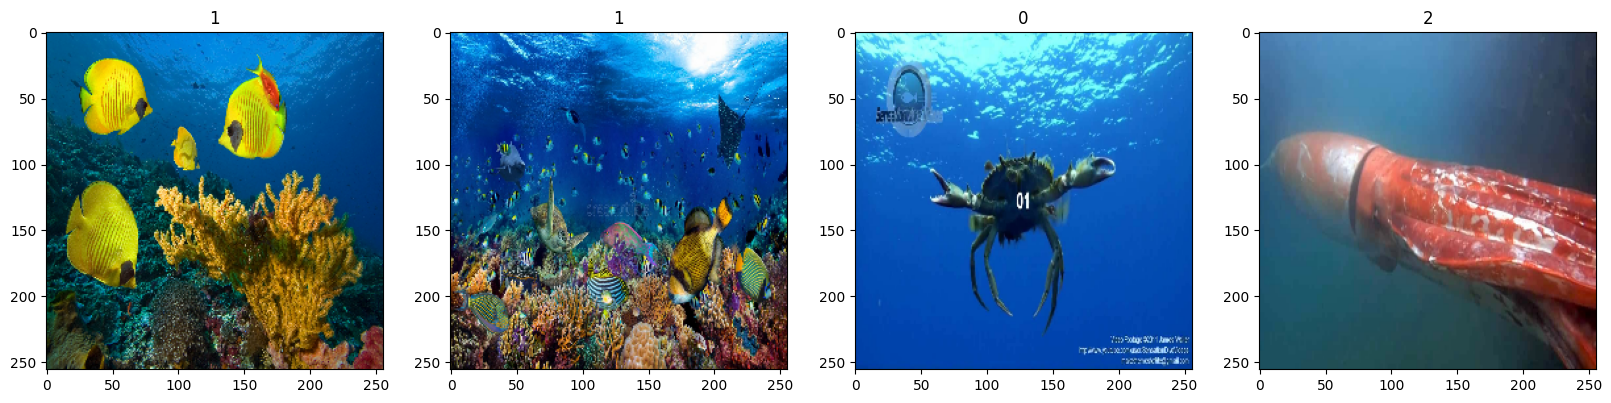

In [17]:
#Visualizes some images, sets title as their label
#0 = crab
#1 = fish
#2 = squid
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing

#### Scale Data

In [18]:
#Want channel values (RGB) to be as small as possible, to help optimize faster
#Divide by 255 (max possible RGB value)
scaled = batch[0]/255
scaled.max()
#Need a way to scale data while data is being loaded through data pipeline

1.0

In [19]:
#Maps function to dsatapoints in pipeline so data x value (which is the image values) get automatically scaled down
#y val = labels
#Allows a function to be conducted on multiple values throughout the dataset
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()

(array([[[[4.39215690e-01, 5.19607842e-01, 2.52941191e-01],
          [4.05882359e-01, 4.58823532e-01, 1.15686275e-01],
          [3.41176480e-01, 4.07843143e-01, 4.31372561e-02],
          ...,
          [3.17647070e-01, 5.72549045e-01, 3.52941185e-01],
          [3.17647070e-01, 5.68627477e-01, 3.33333343e-01],
          [2.96078444e-01, 4.94117647e-01, 2.96078444e-01]],
 
         [[4.60784316e-01, 5.23529410e-01, 2.29411766e-01],
          [4.31372553e-01, 4.84313726e-01, 1.56862751e-01],
          [3.62745106e-01, 4.25490201e-01, 5.49019612e-02],
          ...,
          [3.21568638e-01, 5.76470613e-01, 3.56862754e-01],
          [3.21568638e-01, 5.80392182e-01, 3.41176480e-01],
          [2.98039228e-01, 5.01960814e-01, 3.01960796e-01]],
 
         [[4.23529416e-01, 4.80392158e-01, 1.29411772e-01],
          [4.15686280e-01, 4.72549021e-01, 1.21568628e-01],
          [3.70588243e-01, 4.33333337e-01, 6.27451017e-02],
          ...,
          [3.25490206e-01, 5.80392182e-01, 3.6078

#### Split Data

In [21]:
len(data)

9

In [22]:
#70% training data, 20% validating data, 10% testing data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1) + 1 #Only used for evaluation

In [23]:
val_size + test_size + train_size

9

In [24]:
train = data.take(train_size) #Takes only number of batches from data specified by train_size
val = data.skip(train_size).take(val_size) #Skips first part of data already assigned to training data and takes val_size amount after
test = data.skip(train_size+val_size).take(test_size)

## Building Deep Neural Network

#### Build Deep Learning Model

In [25]:
from tensorflow.keras.models import Sequential #Good for 1 data input and 1 output
#use Functional for multiple inputs/outputs/connections
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model = Sequential()

In [27]:
#16 filters, filter is 3x3 pixels, stride = 1 (moves 1 pixel at a time)
#Activations: Take in output data and modify the outputs via a function to fit certain parameters
#relu activation function takes output and converts <0 outputs to 0, and preserves positive values
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3))) #First layer is input layer
model.add(MaxPooling2D()) #Takes and returns max values after relu activation, condenses

#32 filters
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

#16 filters
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #Condenses to single dimension

#Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='sigmoid')) #Single output, 3 = number of possible outputs (0, 1, 2)

In [28]:
#adam = optimizer
#SparseCategoricalCrossentropy used b/c there are 2+ possible y_values, and they are mutually exclusive (only 1 label per input)
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### Train

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
#Epoch = A run over our entire training set, the more epochs = better understanding
#TOO many epochs could mean too much accuracy for only training data, not very usable
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 7s 453ms/step - loss: 1.1813 - accuracy: 0.4062 - val_loss: 0.9380 - val_accuracy: 0.7031
Epoch 2/20
6/6 [==============================] - 4s 457ms/step - loss: 0.8374 - accuracy: 0.6615 - val_loss: 0.6937 - val_accuracy: 0.6875
Epoch 3/20
6/6 [==============================] - 4s 428ms/step - loss: 0.6587 - accuracy: 0.7396 - val_loss: 0.8358 - val_accuracy: 0.7500
Epoch 4/20
6/6 [==============================] - 4s 434ms/step - loss: 0.6068 - accuracy: 0.7865 - val_loss: 0.6491 - val_accuracy: 0.7344
Epoch 5/20
6/6 [==============================] - 4s 436ms/step - loss: 0.4802 - accuracy: 0.8542 - val_loss: 0.4733 - val_accuracy: 0.8438
Epoch 6/20
6/6 [==============================] - 4s 437ms/step - loss: 0.4345 - accuracy: 0.8177 - val_loss: 0.3262 - val_accuracy: 0.8906
Epoch 7/20
6/6 [==============================] - 4s 443ms/step - loss: 0.3583 - accuracy: 0.8906 - val_loss: 0.2766 - val_accuracy: 0.9375
Epoch 8/20
6/6 [====

In [33]:
hist.history

{'loss': [1.18134343624115,
  0.837351381778717,
  0.6586883664131165,
  0.6068447232246399,
  0.4801594316959381,
  0.4345361292362213,
  0.3583429157733917,
  0.23800380527973175,
  0.2987503111362457,
  0.21809755265712738,
  0.17118830978870392,
  0.08710616081953049,
  0.06735033541917801,
  0.10024097561836243,
  0.06842971593141556,
  0.04074854031205177,
  0.032546523958444595,
  0.020294422283768654,
  0.013176407665014267,
  0.006968955975025892],
 'accuracy': [0.40625,
  0.6614583134651184,
  0.7395833134651184,
  0.7864583134651184,
  0.8541666865348816,
  0.8177083134651184,
  0.890625,
  0.9427083134651184,
  0.8958333134651184,
  0.921875,
  0.9270833134651184,
  0.984375,
  0.9895833134651184,
  0.96875,
  0.9895833134651184,
  1.0,
  0.9895833134651184,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.937975287437439,
  0.693666398525238,
  0.8357958793640137,
  0.6491242051124573,
  0.4733118414878845,
  0.3262491822242737,
  0.2765900790691376,
  0.25221356749534607,
  0.172579

#### Plot Performance

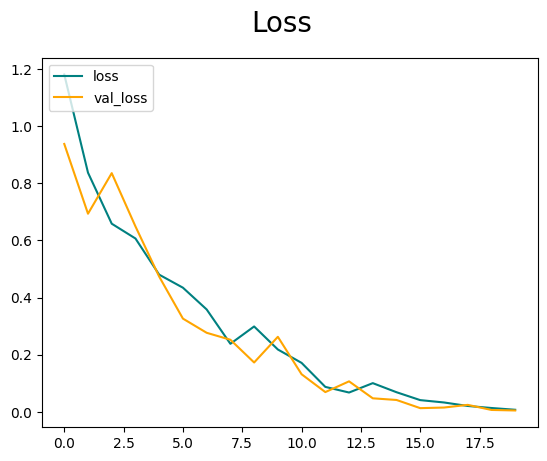

In [34]:
#If loss is decreasing but val_loss starts to increase, that is a sign of possible overfitting
#No change in loss or val_loss means training data should be looked at, or a more sophisticated nn, shows inability to learn 
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle("Loss", fontsize=20)
plt.legend(loc='upper left')
plt.show()

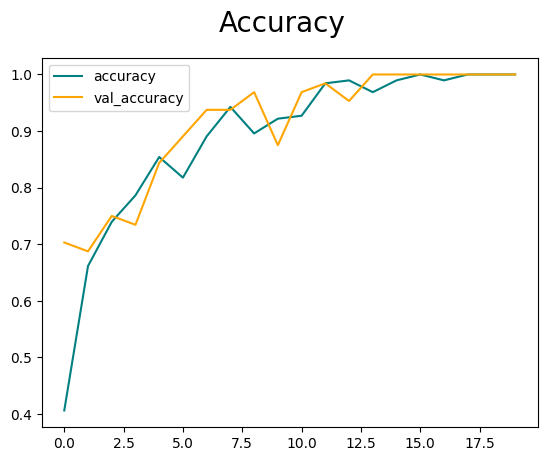

In [35]:
#Accuracy Plotted
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Model Evaluation

#### Evaluate

In [36]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [37]:
pre = Precision()
recall = Recall()
acc = SparseCategoricalAccuracy()

In [54]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    print(y.shape)
    print(yhat.shape)
#     pre.update_state(y, yhat)
#     recall.update_state(y, yhat)
#     accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 27ms/step
(30,)
(30, 3)


#### Testing

In [39]:
import cv2

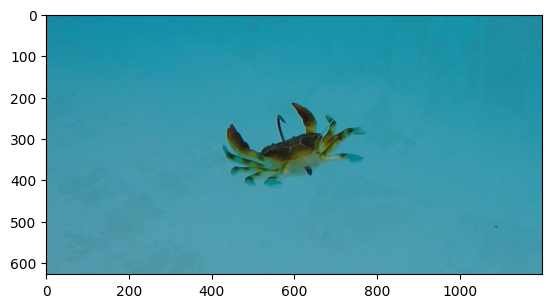

In [63]:
img = cv2.imread('crab-test.jpg')
# plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #Changes channels to RGB, outputs image as normal
plt.show()

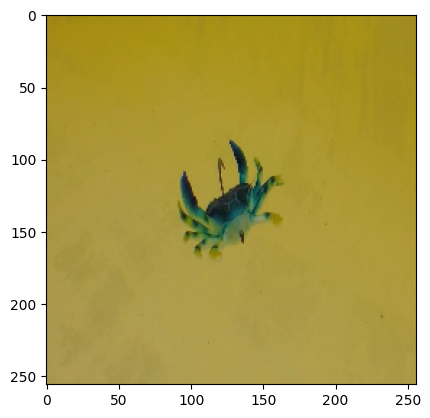

In [64]:
#Resize to be 256x256 and 3 channels
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [65]:
yhat = model.predict(np.expand_dims(resize/255, 0)) #Image needs to be put into array so model can take it in as a batch, use expand_dims

1/1 [==============================] - 0s 17ms/step


In [67]:
yhat

array([[0.5259918 , 0.17281172, 0.64195025]], dtype=float32)